# ARIMA 

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [12]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## Johnson&Johnson Quarterly Earnings per Share 

In [13]:
data = pd.read_csv('data\jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


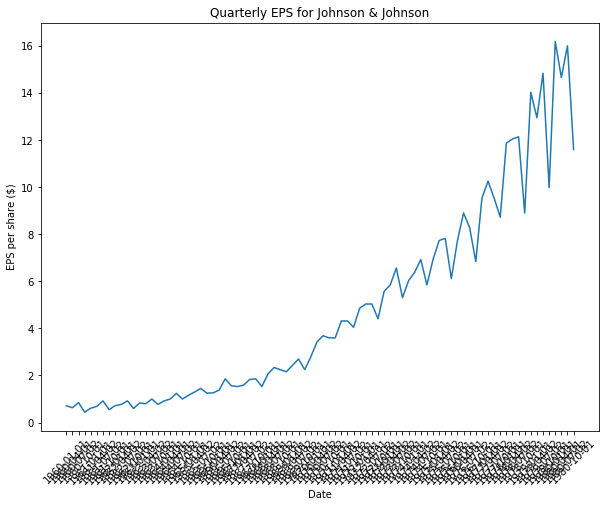

In [14]:
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

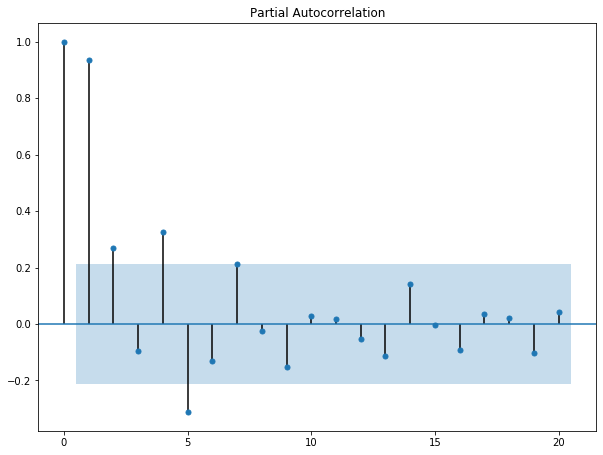

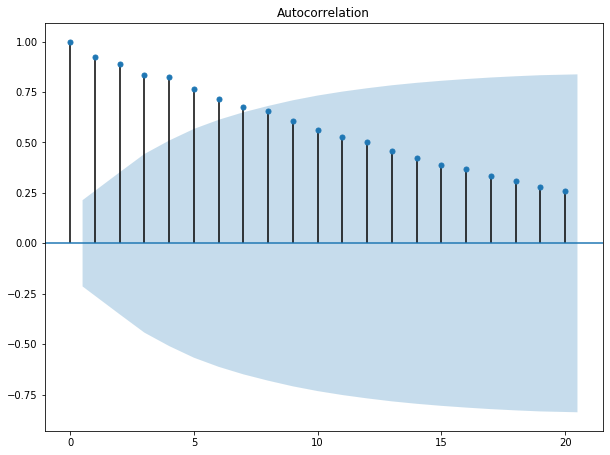

In [15]:
plot_pacf(data['data']);
plot_acf(data['data']);

#ACF and PACF data shows that it is not stationary and ADF test confirms that as well as P-value is not less that .05

In [16]:
ad_fuller_result = adfuller(data['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574766
p-value: 1.0


#As the data 

In [17]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


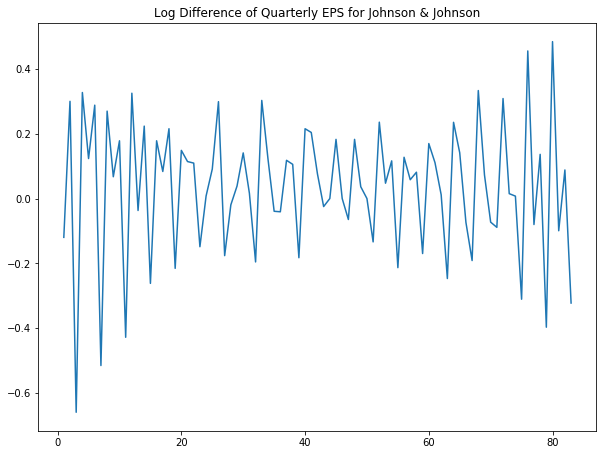

In [18]:
plt.plot(data['data_tr_1'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [19]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811839
p-value: 0.000414973140444062


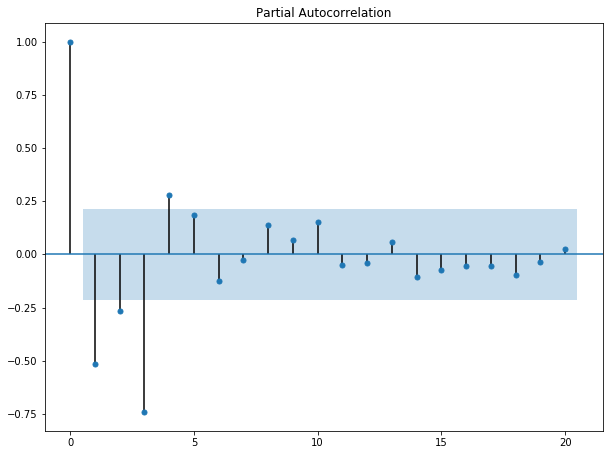

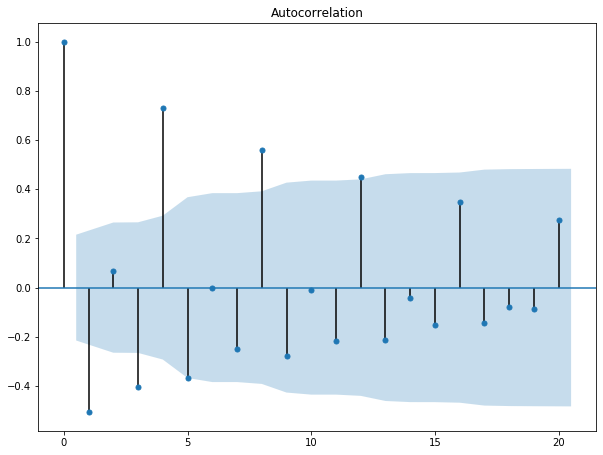

In [20]:
plot_pacf(data['data_tr_1'][1:]);
plot_acf(data['data_tr_1'][1:]);

In [21]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [22]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [23]:
result_df = optimize_ARIMA(data['data'], order_list)
result_df

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.679406
1,"(4, 1, 6)",115.859206
2,"(7, 1, 1)",116.052207
3,"(5, 1, 3)",116.535032
4,"(5, 1, 4)",117.243297
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [24]:
best_model = SARIMAX(data['data'], order=(6,1,3), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.840
Date:                Wed, 17 Feb 2021   AIC                            115.679
Time:                        15:32:26   BIC                            139.868
Sample:                             0   HQIC                           125.397
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4265      0.124    -11.544      0.000      -1.669      -1.184
ar.L2         -0.7148      0.146     -4.889      0.000      -1.001      -0.428
ar.L3          0.0464      0.062      0.752      0.4

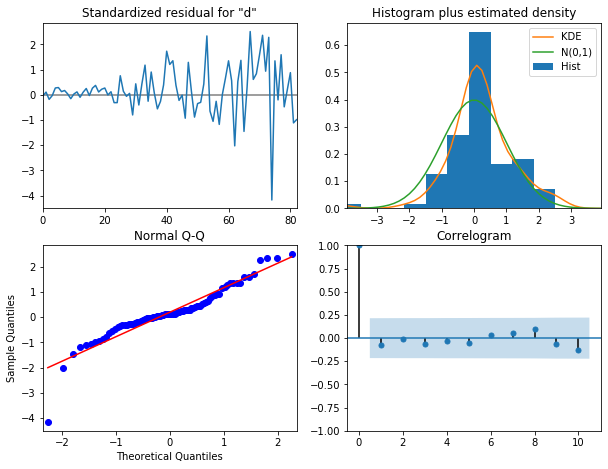

In [25]:
res.plot_diagnostics();

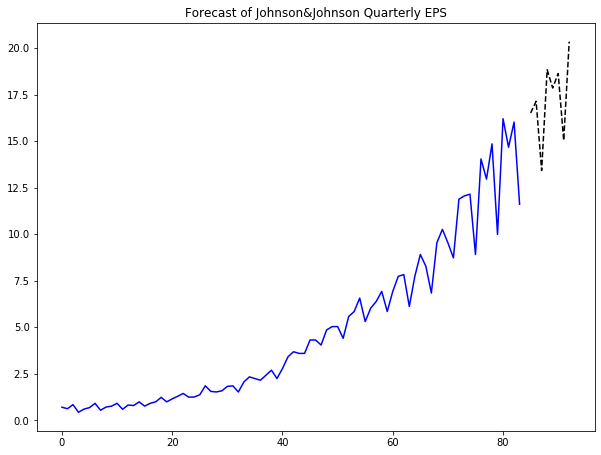

In [26]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Johnson&Johnson Quarterly EPS')
plt.show()

In [27]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.677202
3,1960-10-01,0.44,-0.658462,0.722614
4,1961-01-01,0.61,0.326684,0.650260
5,1961-04-02,0.69,0.123233,0.530025
6,1961-07-02,0.92,0.287682,0.787882
7,1961-10-01,0.55,-0.514455,0.492069
8,1962-01-01,0.72,0.269333,0.645421
9,1962-04-02,0.77,0.067139,0.754627


In [28]:
mse = mean_squared_error(data['data'], data['model'])
print(f'MSE: {mse}')

MSE: 0.16299368722031396
